In [49]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm

# 7 - Prise en compte des données de température pour affiner le modèle

Afin d'améliorer la qualité de la prédiction, il est possible de passer d'un modèle ARMA à un modèle ARMAX pour la consommation désaisonnalisée et dé-trendée, notée $\epsilon_t$. 

Un processus ARMAX(p,q) est de la forme $\epsilon_t= \sum_{i=1}^{4} \phi_i \epsilon_{t-i}+ \sum_{j=1}^{2} \theta_j\varepsilon_{t-j}+ \beta^\top Y_t+ \varepsilon_t$ avec $(\varepsilon_t)$ un bruit blanc.

$Y_t$ contient des variables exogènes, on prendra $(Y_t)=(1,T_{t-2},T_{t-1},T_{t})^{\intercal}$, où $T$ est la température à l'heure $t$, car il est raisonnable de supposer dans un premier temps que les variations instantanées de consommation électrique à l'échelle de la ville de Paris dépendent essentiellement des variations de température survenues dans les deux heures précédentes. 

### 7.1 - Importation des données nettoyées et traitées

Importation des données nettoyées de la température quotidienne : 

In [50]:
dataset = ds.dataset("../data/meteofrance_75_2020_2025_cleaned.parquet")
table = dataset.to_table()
dfmeteo = table.to_pandas()

Importation de la partie résiduelle désaisonnalisée de la consommation électrique quotidienne (*cf.* `pred_conso.ipynb`) :

In [51]:
dfconso = pd.read_csv("residuals_stationary.csv")

### 7.2 - Construction de la variavle exogène $Y_t$

In [52]:
dfmeteo['T'] = (dfmeteo['LUXEMBOURG'] + dfmeteo['MONTSOURIS 1'] + dfmeteo['MONTSOURIS 2'] + dfmeteo['LARIBOISIERE'] + dfmeteo['LONGCHAMP']) / 5
temp = dfmeteo['T']
Y_t = pd.DataFrame({'T_t': temp,'T_t_minus_1': temp.shift(1),'T_t_minus_2': temp.shift(2)})

Afin d'améliorer la stabilité numérique et la robustesse de l'estimation, nous standardisons (standardiser signifie ici centrer et réduire) les données de température : 

In [55]:
scaler = StandardScaler()
Y_t_scaled = pd.DataFrame(scaler.fit_transform(Y_t),index=Y_t.index,columns=Y_t.columns)
Y_t_scaled['1'] = 1  # Ajout de la constante pour le modèle avec intercept
Y_t_scaled = Y_t_scaled.dropna()
Y = dfconso.loc[Y_t_scaled.index]
Y = Y.drop(columns='date_heure')

### 7.3 - Sélection de $p$ et $q$

Étant donné que le modèle retenu pour $\epsilon_t$ sans prise en compte des variations de température était ARMA(4,2), on restreindra notre recherche de $p$ à des valeurs voisines de 4 et notre recherche de $q$ à des valeurs proches de 2. Comme précédemment, nous nous appuierons sur une minimisation du critère d'information Bayesien (BIC), défini cette fois par : 

$BIC = -2\text{log}(L) + (p + q + \text{dim}(Y_t))\text{log}(n)$ avec $L$ la fonction de vraisemblance du modèle, et $n$ la taille de l'échantillon. 

In [57]:
model = pm.auto_arima(
    Y,
    X=Y_t_scaled,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=0,                 
    seasonal=False,
    stepwise=True,
    information_criterion='bic',
    suppress_warnings=True,
    error_action='ignore'
)


print(model.summary())


best_p, best_q = model.order[0], model.order[2]
print(f"Meilleur modèle ARMAX selon BIC : p={best_p}, q={best_q}")

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                52299
Model:               SARIMAX(2, 0, 2)   Log Likelihood             -322125.620
Date:                Mon, 29 Dec 2025   AIC                         644269.241
Time:                        15:35:42   BIC                         644349.023
Sample:                             0   HQIC                        644294.180
                              - 52299                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
T_t          -124.3166      5.599    -22.205      0.000    -135.290    -113.343
T_t_minus_1   208.7912      7.888     26.468      0.000     193.330     224.252
T_t_minus_2  -115.9006      5.833    -19.868    

La détermination du modèle par minimisation du BIC abouti à $p = 2$ et $q = 2$. La p-value associée au test de Ljung-Box de blancheur des résidus est de 0.51 > 0.5 donc les résidus sont bien blancs, ce qui valide le modèle ARMAX avec prise ne compte de la température pour le moment.

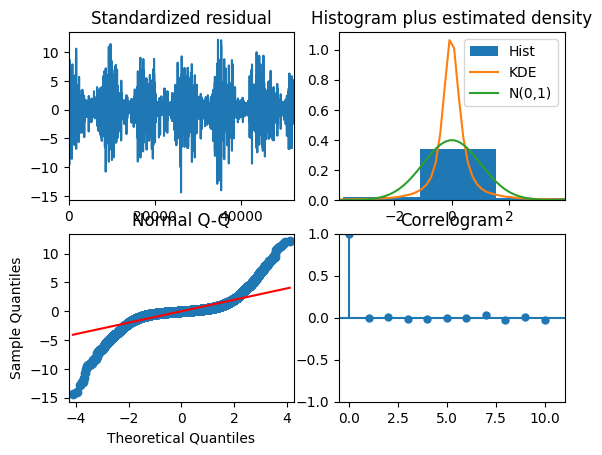

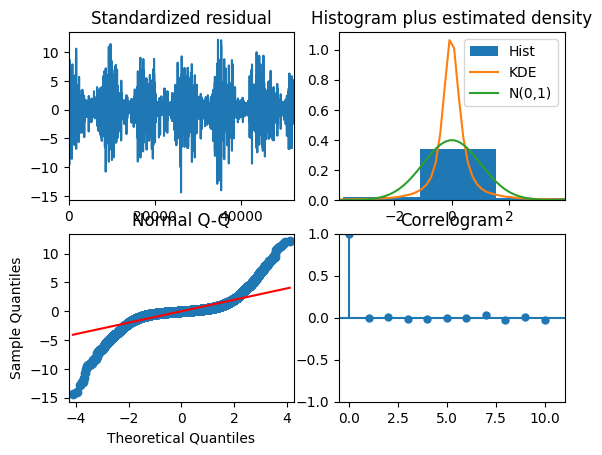

In [58]:
model.plot_diagnostics()